In [1]:
import numpy as np
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [2]:
df_train = pd.read_csv('../kaggle_dataset/dataset_1/Training.csv')
df_train.drop(df_train.columns[df_train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
train_labels = df_train.pop('prognosis')
train_symptoms = df_train.to_numpy()
train_symptoms = train_symptoms.astype(float)#[..., np.newaxis]
print('shape train symptoms:',train_symptoms.shape)
print('shape train labels:',train_labels.shape)

shape train symptoms: (4920, 132)
shape train labels: (4920,)


In [3]:
df_test = pd.read_csv('../kaggle_dataset/dataset_1/Testing.csv')
df_test.drop(df_test.columns[df_test.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test_labels = df_test.pop('prognosis')
test_symptoms = df_test.to_numpy()
test_symptoms = test_symptoms.astype(float)#[..., np.newaxis]
print('shape test symptoms:',test_symptoms.shape)
print('shape test labels:',test_labels.shape)

shape test symptoms: (42, 132)
shape test labels: (42,)


In [4]:
labels_unique = train_labels.unique()
labels_unique = pd.Series(np.sort(labels_unique, axis=-1, kind='mergesort'))
labels_unique

0     (vertigo) Paroymsal  Positional Vertigo
1                                        AIDS
2                                        Acne
3                         Alcoholic hepatitis
4                                     Allergy
5                                   Arthritis
6                            Bronchial Asthma
7                        Cervical spondylosis
8                                 Chicken pox
9                         Chronic cholestasis
10                                Common Cold
11                                     Dengue
12                                  Diabetes 
13               Dimorphic hemmorhoids(piles)
14                              Drug Reaction
15                           Fungal infection
16                                       GERD
17                            Gastroenteritis
18                               Heart attack
19                                Hepatitis B
20                                Hepatitis C
21                                

In [5]:
def to_category(key):
    ret = 999
    for i in range(len(labels_unique)):
        if key == labels_unique[i]:
            ret = i
            break
    return ret

In [6]:
train_labels_cat = []
for i in tqdm(range(len(train_labels))):
    train_labels_cat.append(to_category(train_labels[i]))
    
test_labels_cat = []
for i in tqdm(range(len(test_labels))):
    test_labels_cat.append(to_category(test_labels[i])) 
    
train_labels_cat = np.array(train_labels_cat)
test_labels_cat = np.array(test_labels_cat)

100%|██████████| 42/42 [00:00<00:00, 5197.86it/s]


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, input_shape=(len(train_symptoms[0]),), activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(41, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               68096     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 41)                10537     
Total params: 209,961
Trainable params: 209,961
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
history = model.fit(train_symptoms, train_labels_cat, batch_size = 16, epochs = 10, validation_data=(test_symptoms, test_labels_cat))

Epoch 1/10
308/308 [==============================] - 3s 7ms/step - loss: 1.4766 - accuracy: 0.7473 - val_loss: 0.0373 - val_accuracy: 1.0000
Epoch 2/10
308/308 [==============================] - 1s 4ms/step - loss: 0.0086 - accuracy: 0.9993 - val_loss: 0.0376 - val_accuracy: 0.9762
Epoch 3/10
308/308 [==============================] - 1s 4ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0325 - val_accuracy: 1.0000
Epoch 4/10
308/308 [==============================] - 1s 3ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0439 - val_accuracy: 0.9762
Epoch 5/10
308/308 [==============================] - 1s 3ms/step - loss: 6.0400e-04 - accuracy: 1.0000 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 6/10
308/308 [==============================] - 1s 3ms/step - loss: 5.2766e-04 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 0.9762
Epoch 7/10
308/308 [==============================] - 1s 3ms/step - loss: 3.5914e-04 - accuracy: 1.0000 - val_loss: 0.0417 - val_accuracy: 0

2/2 - 0s - loss: 0.0395 - accuracy: 0.9762
0.976190447807312


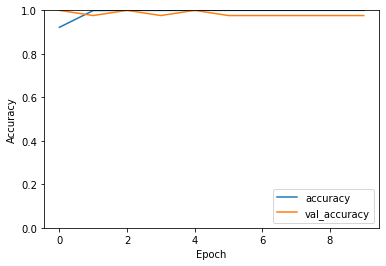

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_symptoms, test_labels_cat, verbose=2)
print(test_acc)

In [11]:
predictions = model.predict(test_symptoms)
predictions[0]

array([1.0836061e-09, 2.6013205e-09, 3.1216281e-08, 6.9737272e-11,
       1.2451390e-08, 2.6626829e-10, 5.6727939e-10, 1.4061123e-09,
       8.7228031e-08, 2.6391641e-08, 4.0918429e-09, 5.5746425e-09,
       5.6854597e-09, 2.2972078e-09, 2.2067912e-08, 9.9999964e-01,
       1.3398959e-09, 1.2580406e-10, 1.5329221e-10, 9.4745962e-09,
       4.0081594e-11, 1.1915440e-09, 6.4059891e-10, 5.0586313e-10,
       8.6107349e-10, 1.2137733e-09, 1.0565337e-09, 4.8060911e-09,
       3.7333354e-08, 1.0983734e-10, 1.2585062e-10, 1.1384396e-09,
       5.2046190e-09, 1.8311995e-10, 3.1813800e-09, 7.2153789e-08,
       2.9001332e-10, 8.5729522e-12, 1.8370084e-08, 4.3459827e-10,
       1.7000101e-10], dtype=float32)

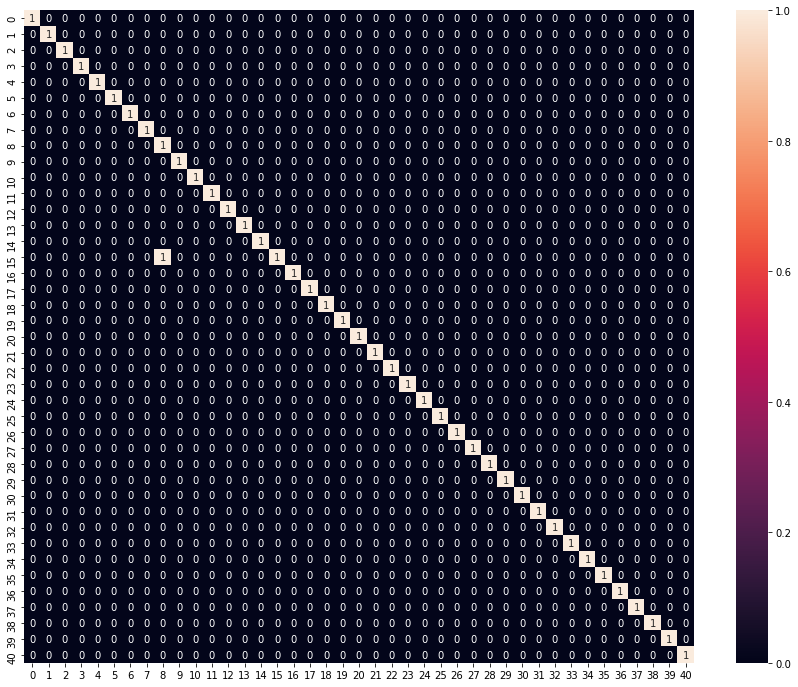

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

pred = []
for i in range(len(predictions)):
    pred.append(np.argmax(predictions[i]))

matrix_conf = confusion_matrix(test_labels_cat, pred)

df_cm = pd.DataFrame(matrix_conf, range(41), range(41))
plt.figure(figsize=(15,12))
# sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size

plt.show()

In [13]:
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(41))
    plt.yticks([])
    thisplot = plt.bar(range(41), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [14]:
def get_label_with_value(predictions_array):
    label_res = []
    for i in range(len(labels_unique)):
        label_res.append(labels_unique[i] + ' {:.2f} %'.format(predictions_array[i]*100))
    return label_res

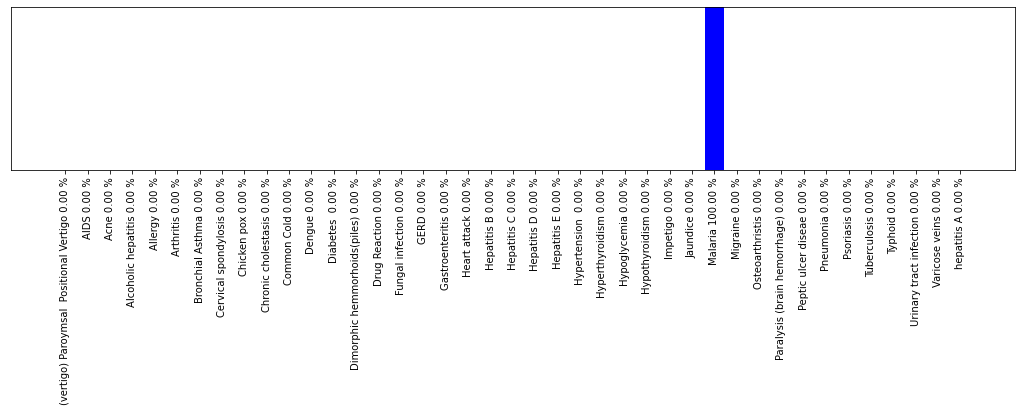

In [15]:
i = 15
plt.figure(figsize=(18,3))
plot_value_array(i, predictions[i],  test_labels_cat)
_ = plt.xticks(range(41), get_label_with_value(predictions[i]), rotation=90)
plt.show()

In [16]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5_py0dn6/assets
